# Correlating conformational changes to affinity

## Introduction

The following notebook aims to correlate the changes observed between *apo* and *holo* conformations with the affinity of the interactions. The ATLAS dataset is be used to collect affinities on the interactions.

In [1]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

## Loading and cleaning the ATLAS dataset

In [2]:
atlas = pd.read_excel('../data/external/ATLAS.xlsx', sheet_name='Mutants_052016', index_col='Index')
atlas

,TCRname,MHCname,MHCname_PDB,MHC_mut,MHC_mut_chain,TCR_mut,Kd_microM,Kon_per_M_per_s,Koff_per_s,Kd_wt/Kd_mut,...,TCR_mut_chain,CDR,wtCDRseq,TCR_PDB_chain,PMID,Exp. Method,SPR SensorChip,Immobilized Ligand,Coupling Method,Analyte
Index,,,,,,,,,,,,,,,,,,,,,
1,LC13,HLA-B*08:01,HLA-B*08:01,WT,NaN,WT,12.5 +/- 2.1,\N,\N,1,...,NaN,\N,\N,\N,15640805,Biacore 3000,CM5,FLRGRAYGL-HLA-B*08:01,direct,LC13 WT
2,LC13,HLA-B*08:01,HLA-B*08:01,WT,NaN,S25A,14.8 +/- 0.55,\N,\N,0.84,...,A,CDR1,TISGTDY,D,15640805,Biacore 3000,CM5,FLRGRAYGL-HLA-B*08:01,direct,LC13 S25A
3,LC13,HLA-B*08:01,HLA-B*08:01,WT,NaN,T26A,19.4 +/- 0.55,\N,\N,0.64,...,A,CDR1,TISGTDY,D,15640805,Biacore 3000,CM5,FLRGRAYGL-HLA-B*08:01,direct,LC13 T26A
4,LC13,HLA-B*08:01,HLA-B*08:01,WT,NaN,S28A,11.7 +/- 0.85,\N,\N,1.07,...,A,CDR1,TISGTDY,D,15640805,Biacore 3000,CM5,FLRGRAYGL-HLA-B*08:01,direct,LC13 S28A
5,LC13,HLA-B*08:01,HLA-B*08:01,WT,NaN,T30A,33.7 +/- 1.2,\N,\N,0.37,...,A,CDR1,TISGTDY,D,15640805,Biacore 3000,CM5,FLRGRAYGL-HLA-B*08:01,direct,LC13 T30A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,2B4,I-Ek,I-Ek,WT,NaN,WT,n.d.,n.d.,n.d.,NaN,...,NaN,NaN,NaN,NaN,12152083,Biacore,NaN,ANERADLIAYLKQAAK-IEk,indirect,2B4 WT
691,2B4,I-Ek,I-Ek,WT,NaN,WT,33.8,3950,0.134,0.16,...,NaN,NaN,NaN,NaN,12152083,Biacore,NaN,ANERADLIAYLKQASK-IEk,indirect,2B4 WT
692,2B4,I-Ek,I-Ek,WT,NaN,WT,43.4,4030,680,0.13,...,NaN,NaN,NaN,NaN,12152083,Biacore,NaN,ANERADLIAYLKQANK-IEk,indirect,2B4 WT


In [3]:
atlas_with_pdb = atlas.query('true_PDB.notna()').copy()

In [4]:
atlas_with_pdb_wt = atlas_with_pdb.query("MHC_mut == TCR_mut == 'WT'").copy()

In [5]:
pattern = re.compile(r'\s*\+/\-\s*')

kds = atlas_with_pdb_wt['Kd_microM'].apply(str).map(pattern.split).apply(pd.Series)
kds.columns = ['kd', 'error']
kds = kds.replace('n.d.', np.nan)
kds.loc[kds['kd'].fillna('').str.startswith('>'), 'kd'] = np.nan

kds['kd'] = kds['kd'].apply(float)
kds['error'] = kds['error'].apply(float)

atlas_with_pdb_wt[['kd', 'kd_error']] = kds

atlas_with_pdb_wt = atlas_with_pdb_wt[atlas_with_pdb_wt['kd'].notnull()].copy()

atlas_with_pdb_wt

,TCRname,MHCname,MHCname_PDB,MHC_mut,MHC_mut_chain,TCR_mut,Kd_microM,Kon_per_M_per_s,Koff_per_s,Kd_wt/Kd_mut,...,wtCDRseq,TCR_PDB_chain,PMID,Exp. Method,SPR SensorChip,Immobilized Ligand,Coupling Method,Analyte,kd,kd_error
Index,,,,,,,,,,,,,,,,,,,,,
1,LC13,HLA-B*08:01,HLA-B*08:01,WT,NaN,WT,12.5 +/- 2.1,\N,\N,1,...,\N,\N,15640805,Biacore 3000,CM5,FLRGRAYGL-HLA-B*08:01,direct,LC13 WT,12.500000,2.1
40,JM22,HLA-A*02:01,HLA-A*02:01,WT,NaN,WT,5.2,31000,0.16,1,...,\N,\N,18275829,Biacore 2000,CM5,GILGFVFTL-HLA-A*02:01,indirect,JM22 WT,5.200000,NaN
63,A6,HLA-A*02:01,HLA-A*02:01,WT,NaN,WT,2.113503,51100,0.108,1,...,\N,\N,18767161,Biacore 3000,CM5,A6 WT,direct,LLFGYPVYV-HLA-A*02:01,2.113503,NaN
90,RA14,HLA-A*02:01,HLA-A*02:01,WT,NaN,WT,27.7 +/- 2.3,\N,\N,1,...,\N,\N,19542454,Biacore 3000,CM5,RA14 WT,direct,NLVPMVATV-HLA-A*02:01,27.700000,2.3
100,MEL5,HLA-A*02:01,HLA-A*02:01,WT,NaN,WT,18,\N,\N,0.36,...,\N,\N,19605354,Biacore T100,CM5,ELAGIGILTV-HLA-A*02:01,indirect,MEL5 WT,18.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,42F3,H-2Ld,H-2Ld,WT,NaN,WT,48,NaN,NaN,NaN,...,NaN,NaN,22301545,NaN,NaN,NaN,NaN,NaN,48.000000,NaN
666,J809.B5,I-Ab,I-Ab,WT,NaN,WT,32,NaN,NaN,NaN,...,NaN,NaN,24813203,Biacore 3000,NaN,FEAQKAKANKAVD-IAb,indirect,J809.B5 WT,32.000000,NaN
668,14.C6,I-Ab,I-Ab,WT,NaN,WT,5,NaN,NaN,NaN,...,NaN,NaN,24813203,Biacore 3000,NaN,FEAQKAKANKAVD-IAb,indirect,14.C6 WT,5.000000,NaN


In [6]:
atlas_with_pdb_wt['pdb_id'] = atlas_with_pdb['true_PDB'].str.lower()

In [7]:
num_structures_in_atlas = len(atlas_with_pdb_wt['pdb_id'].unique())

print('There are', num_structures_in_atlas, 'structures in the ATLAS dataset with affinity data for the wild type structures')

There are 73 structures in the ATLAS dataset with affinity data for the wild type structures


## Loading apo-holo dataset

In [8]:
summary_df = pd.read_csv('../data/processed/apo-holo-tcr-pmhc-class-I/apo_holo_summary.csv')
summary_df

,file_name,pdb_id,structure_type,state,alpha_chain,beta_chain,antigen_chain,mhc_chain1,mhc_chain2,cdr_sequences_collated,peptide_sequence,mhc_slug
0,1ao7_D-E-C-A-B_tcr_pmhc.pdb,1ao7,tcr_pmhc,holo,D,E,C,A,B,DRGSQS-IYSNGD-AVTTDSWGKLQ-MNHEY-SVGAGI-ASRPGLA...,LLFGYPVYV,hla_a_02_01
1,1b0g_C-A-B_pmhc.pdb,1b0g,pmhc,apo,NaN,NaN,C,A,B,NaN,ALWGFFPVL,hla_a_02_01
2,1b0g_F-D-E_pmhc.pdb,1b0g,pmhc,apo,NaN,NaN,F,D,E,NaN,ALWGFFPVL,hla_a_02_01
3,1bd2_D-E-C-A-B_tcr_pmhc.pdb,1bd2,tcr_pmhc,holo,D,E,C,A,B,NSMFDY-ISSIKDK-AAMEGAQKLV-MNHEY-SVGAGI-ASSYPGG...,LLFGYPVYV,hla_a_02_01
4,1bii_P-A-B_pmhc.pdb,1bii,pmhc,apo,NaN,NaN,P,A,B,NaN,RGPGRAFVTI,h2_dd
...,...,...,...,...,...,...,...,...,...,...,...,...
386,7rtd_C-A-B_pmhc.pdb,7rtd,pmhc,apo,NaN,NaN,C,A,B,NaN,YLQPRTFLL,hla_a_02_01
387,7rtr_D-E-C-A-B_tcr_pmhc.pdb,7rtr,tcr_pmhc,holo,D,E,C,A,B,DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,YLQPRTFLL,hla_a_02_01
388,8gvb_A-B-P-H-L_tcr_pmhc.pdb,8gvb,tcr_pmhc,holo,A,B,P,H,L,YGATPY-YFSGDTLV-AVGFTGGGNKLT-SEHNR-FQNEAQ-ASSD...,RYPLTFGW,hla_a_24_02
389,8gvg_A-B-P-H-L_tcr_pmhc.pdb,8gvg,tcr_pmhc,holo,A,B,P,H,L,YGATPY-YFSGDTLV-AVGFTGGGNKLT-SEHNR-FQNEAQ-ASSD...,RFPLTFGW,hla_a_24_02


In [9]:
summary_df['id'] = summary_df['file_name'].str.replace(r'.pdb$', '', regex=True)
summary_df = summary_df.set_index('id')

## Loading TCR data

In [10]:
conformational_change_tcr = pd.read_csv('../data/processed/apo-holo-tcr-pmhc-class-I-comparisons/rmsd_cdr_fw_align_results.csv')
conformational_change_tcr

,complex_id,structure_x_name,structure_y_name,chain_type,cdr,rmsd
0,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,alpha_chain,1,1.932806
1,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,alpha_chain,2,1.308598
2,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,alpha_chain,3,1.244062
3,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,beta_chain,1,0.809066
4,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,beta_chain,2,0.688597
...,...,...,...,...,...,...
809,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,alpha_chain,2,0.810170
810,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,alpha_chain,3,0.563263
811,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,beta_chain,1,0.399182
812,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,beta_chain,2,0.284455


In [11]:
conformational_change_tcr = conformational_change_tcr.merge(
    summary_df[['file_name', 'pdb_id', 'structure_type', 'state']],
    how='left',
    left_on='structure_x_name',
    right_on='file_name',
).merge(
    summary_df[['file_name', 'pdb_id', 'structure_type', 'state']],
    how='left',
    left_on='structure_y_name',
    right_on='file_name',
    suffixes=('_x', '_y')
).merge(
    summary_df[['cdr_sequences_collated', 'peptide_sequence', 'mhc_slug']],
    how='left',
    left_on='complex_id',
    right_index=True,
)

conformational_change_tcr

,complex_id,structure_x_name,structure_y_name,chain_type,cdr,rmsd,file_name_x,pdb_id_x,structure_type_x,state_x,file_name_y,pdb_id_y,structure_type_y,state_y,cdr_sequences_collated,peptide_sequence,mhc_slug
0,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,alpha_chain,1,1.932806,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qdg,tcr_pmhc,holo,3qeu_A-B_tcr.pdb,3qeu,tcr,apo,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,ELAGIGILTV,hla_a_02_01
1,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,alpha_chain,2,1.308598,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qdg,tcr_pmhc,holo,3qeu_A-B_tcr.pdb,3qeu,tcr,apo,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,ELAGIGILTV,hla_a_02_01
2,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,alpha_chain,3,1.244062,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qdg,tcr_pmhc,holo,3qeu_A-B_tcr.pdb,3qeu,tcr,apo,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,ELAGIGILTV,hla_a_02_01
3,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,beta_chain,1,0.809066,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qdg,tcr_pmhc,holo,3qeu_A-B_tcr.pdb,3qeu,tcr,apo,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,ELAGIGILTV,hla_a_02_01
4,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,beta_chain,2,0.688597,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qdg,tcr_pmhc,holo,3qeu_A-B_tcr.pdb,3qeu,tcr,apo,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,ELAGIGILTV,hla_a_02_01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,alpha_chain,2,0.810170,7n1d_A-B_tcr.pdb,7n1d,tcr,apo,7rtr_D-E-C-A-B_tcr_pmhc.pdb,7rtr,tcr_pmhc,holo,DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,YLQPRTFLL,hla_a_02_01
810,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,alpha_chain,3,0.563263,7n1d_A-B_tcr.pdb,7n1d,tcr,apo,7rtr_D-E-C-A-B_tcr_pmhc.pdb,7rtr,tcr_pmhc,holo,DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,YLQPRTFLL,hla_a_02_01
811,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,beta_chain,1,0.399182,7n1d_A-B_tcr.pdb,7n1d,tcr,apo,7rtr_D-E-C-A-B_tcr_pmhc.pdb,7rtr,tcr_pmhc,holo,DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,YLQPRTFLL,hla_a_02_01
812,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,beta_chain,2,0.284455,7n1d_A-B_tcr.pdb,7n1d,tcr,apo,7rtr_D-E-C-A-B_tcr_pmhc.pdb,7rtr,tcr_pmhc,holo,DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,YLQPRTFLL,hla_a_02_01


In [12]:
conformational_change_tcr['comparison'] = conformational_change_tcr['state_x'] + '-' + conformational_change_tcr['state_y']
conformational_change_tcr['comparison'] = conformational_change_tcr['comparison'].map(lambda entry: 'apo-holo' if entry == 'holo-apo' else entry)

In [13]:
conformational_change_tcr['structure_comparison'] = conformational_change_tcr.apply(
    lambda row: '-'.join(sorted([row.structure_x_name, row.structure_y_name])),
    axis='columns',
)
conformational_change_tcr = conformational_change_tcr.drop_duplicates(['structure_comparison',
                                                                       'chain_type',
                                                                       'cdr']).copy()

In [14]:
conformational_change_tcr

,complex_id,structure_x_name,structure_y_name,chain_type,cdr,rmsd,file_name_x,pdb_id_x,structure_type_x,state_x,file_name_y,pdb_id_y,structure_type_y,state_y,cdr_sequences_collated,peptide_sequence,mhc_slug,comparison,structure_comparison
0,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,alpha_chain,1,1.932806,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qdg,tcr_pmhc,holo,3qeu_A-B_tcr.pdb,3qeu,tcr,apo,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,ELAGIGILTV,hla_a_02_01,apo-holo,3qdg_D-E-C-A-B_tcr_pmhc.pdb-3qeu_A-B_tcr.pdb
1,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,alpha_chain,2,1.308598,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qdg,tcr_pmhc,holo,3qeu_A-B_tcr.pdb,3qeu,tcr,apo,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,ELAGIGILTV,hla_a_02_01,apo-holo,3qdg_D-E-C-A-B_tcr_pmhc.pdb-3qeu_A-B_tcr.pdb
2,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,alpha_chain,3,1.244062,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qdg,tcr_pmhc,holo,3qeu_A-B_tcr.pdb,3qeu,tcr,apo,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,ELAGIGILTV,hla_a_02_01,apo-holo,3qdg_D-E-C-A-B_tcr_pmhc.pdb-3qeu_A-B_tcr.pdb
3,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,beta_chain,1,0.809066,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qdg,tcr_pmhc,holo,3qeu_A-B_tcr.pdb,3qeu,tcr,apo,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,ELAGIGILTV,hla_a_02_01,apo-holo,3qdg_D-E-C-A-B_tcr_pmhc.pdb-3qeu_A-B_tcr.pdb
4,3qdg_D-E-C-A-B_tcr_pmhc,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qeu_A-B_tcr.pdb,beta_chain,2,0.688597,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qdg,tcr_pmhc,holo,3qeu_A-B_tcr.pdb,3qeu,tcr,apo,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,ELAGIGILTV,hla_a_02_01,apo-holo,3qdg_D-E-C-A-B_tcr_pmhc.pdb-3qeu_A-B_tcr.pdb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,alpha_chain,2,0.810170,7n1d_A-B_tcr.pdb,7n1d,tcr,apo,7rtr_D-E-C-A-B_tcr_pmhc.pdb,7rtr,tcr_pmhc,holo,DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,YLQPRTFLL,hla_a_02_01,apo-holo,7n1d_A-B_tcr.pdb-7rtr_D-E-C-A-B_tcr_pmhc.pdb
810,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,alpha_chain,3,0.563263,7n1d_A-B_tcr.pdb,7n1d,tcr,apo,7rtr_D-E-C-A-B_tcr_pmhc.pdb,7rtr,tcr_pmhc,holo,DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,YLQPRTFLL,hla_a_02_01,apo-holo,7n1d_A-B_tcr.pdb-7rtr_D-E-C-A-B_tcr_pmhc.pdb
811,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,beta_chain,1,0.399182,7n1d_A-B_tcr.pdb,7n1d,tcr,apo,7rtr_D-E-C-A-B_tcr_pmhc.pdb,7rtr,tcr_pmhc,holo,DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,YLQPRTFLL,hla_a_02_01,apo-holo,7n1d_A-B_tcr.pdb-7rtr_D-E-C-A-B_tcr_pmhc.pdb
812,7rtr_D-E-C-A-B_tcr_pmhc,7n1d_A-B_tcr.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,beta_chain,2,0.284455,7n1d_A-B_tcr.pdb,7n1d,tcr,apo,7rtr_D-E-C-A-B_tcr_pmhc.pdb,7rtr,tcr_pmhc,holo,DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,YLQPRTFLL,hla_a_02_01,apo-holo,7n1d_A-B_tcr.pdb-7rtr_D-E-C-A-B_tcr_pmhc.pdb


## Loading pMHC Data

In [15]:
conformational_change_pmhc = pd.read_csv('../data/processed/apo-holo-tcr-pmhc-class-I-comparisons/pmhc_tcr_contact_apo_holo.csv')
conformational_change_pmhc

,complex_id,structure_x_name,structure_y_name,chain_type,tcr_contact,rmsd
0,3qdg_D-E-C-A-B_tcr_pmhc,1jf1_C-A-B_pmhc.pdb,3qdg_D-E-C-A-B_tcr_pmhc.pdb,mhc_chain1,False,0.630013
1,3qdg_D-E-C-A-B_tcr_pmhc,1jf1_C-A-B_pmhc.pdb,3qdg_D-E-C-A-B_tcr_pmhc.pdb,mhc_chain1,True,0.582077
2,5c0a_D-E-C-A-B_tcr_pmhc,5c0a_D-E-C-A-B_tcr_pmhc.pdb,5n1y_C-A-B_pmhc.pdb,antigen_chain,False,0.448858
3,5c0a_D-E-C-A-B_tcr_pmhc,5c0a_D-E-C-A-B_tcr_pmhc.pdb,5n1y_C-A-B_pmhc.pdb,mhc_chain1,False,0.422160
4,5c0a_D-E-C-A-B_tcr_pmhc,5c0a_D-E-C-A-B_tcr_pmhc.pdb,5n1y_C-A-B_pmhc.pdb,mhc_chain1,True,0.424287
...,...,...,...,...,...,...
3311,7rtr_D-E-C-A-B_tcr_pmhc,7p3d_C-A-B_pmhc.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,mhc_chain1,False,0.497769
3312,7rtr_D-E-C-A-B_tcr_pmhc,7p3d_C-A-B_pmhc.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,mhc_chain1,True,0.458372
3313,7rtr_D-E-C-A-B_tcr_pmhc,7rtd_C-A-B_pmhc.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,antigen_chain,False,0.455078
3314,7rtr_D-E-C-A-B_tcr_pmhc,7rtd_C-A-B_pmhc.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,mhc_chain1,False,0.449558


In [16]:
conformational_change_pmhc = conformational_change_pmhc.merge(
    summary_df[['file_name', 'pdb_id', 'structure_type', 'state']],
    how='left',
    left_on='structure_x_name',
    right_on='file_name',
).merge(
    summary_df[['file_name', 'pdb_id', 'structure_type', 'state']],
    how='left',
    left_on='structure_y_name',
    right_on='file_name',
    suffixes=('_x', '_y')
).merge(
    summary_df[['cdr_sequences_collated', 'peptide_sequence', 'mhc_slug']],
    how='left',
    left_on='complex_id',
    right_index=True,
)

conformational_change_pmhc

,complex_id,structure_x_name,structure_y_name,chain_type,tcr_contact,rmsd,file_name_x,pdb_id_x,structure_type_x,state_x,file_name_y,pdb_id_y,structure_type_y,state_y,cdr_sequences_collated,peptide_sequence,mhc_slug
0,3qdg_D-E-C-A-B_tcr_pmhc,1jf1_C-A-B_pmhc.pdb,3qdg_D-E-C-A-B_tcr_pmhc.pdb,mhc_chain1,False,0.630013,1jf1_C-A-B_pmhc.pdb,1jf1,pmhc,apo,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qdg,tcr_pmhc,holo,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,ELAGIGILTV,hla_a_02_01
1,3qdg_D-E-C-A-B_tcr_pmhc,1jf1_C-A-B_pmhc.pdb,3qdg_D-E-C-A-B_tcr_pmhc.pdb,mhc_chain1,True,0.582077,1jf1_C-A-B_pmhc.pdb,1jf1,pmhc,apo,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qdg,tcr_pmhc,holo,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,ELAGIGILTV,hla_a_02_01
2,5c0a_D-E-C-A-B_tcr_pmhc,5c0a_D-E-C-A-B_tcr_pmhc.pdb,5n1y_C-A-B_pmhc.pdb,antigen_chain,False,0.448858,5c0a_D-E-C-A-B_tcr_pmhc.pdb,5c0a,tcr_pmhc,holo,5n1y_C-A-B_pmhc.pdb,5n1y,pmhc,apo,NSAFQY-TYSSGN-AMRGDSSYKLI-SGHDY-FNNNVP-ASSLWEK...,MVWGPDPLYV,hla_a_02_01
3,5c0a_D-E-C-A-B_tcr_pmhc,5c0a_D-E-C-A-B_tcr_pmhc.pdb,5n1y_C-A-B_pmhc.pdb,mhc_chain1,False,0.422160,5c0a_D-E-C-A-B_tcr_pmhc.pdb,5c0a,tcr_pmhc,holo,5n1y_C-A-B_pmhc.pdb,5n1y,pmhc,apo,NSAFQY-TYSSGN-AMRGDSSYKLI-SGHDY-FNNNVP-ASSLWEK...,MVWGPDPLYV,hla_a_02_01
4,5c0a_D-E-C-A-B_tcr_pmhc,5c0a_D-E-C-A-B_tcr_pmhc.pdb,5n1y_C-A-B_pmhc.pdb,mhc_chain1,True,0.424287,5c0a_D-E-C-A-B_tcr_pmhc.pdb,5c0a,tcr_pmhc,holo,5n1y_C-A-B_pmhc.pdb,5n1y,pmhc,apo,NSAFQY-TYSSGN-AMRGDSSYKLI-SGHDY-FNNNVP-ASSLWEK...,MVWGPDPLYV,hla_a_02_01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3311,7rtr_D-E-C-A-B_tcr_pmhc,7p3d_C-A-B_pmhc.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,mhc_chain1,False,0.497769,7p3d_C-A-B_pmhc.pdb,7p3d,pmhc,apo,7rtr_D-E-C-A-B_tcr_pmhc.pdb,7rtr,tcr_pmhc,holo,DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,YLQPRTFLL,hla_a_02_01
3312,7rtr_D-E-C-A-B_tcr_pmhc,7p3d_C-A-B_pmhc.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,mhc_chain1,True,0.458372,7p3d_C-A-B_pmhc.pdb,7p3d,pmhc,apo,7rtr_D-E-C-A-B_tcr_pmhc.pdb,7rtr,tcr_pmhc,holo,DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,YLQPRTFLL,hla_a_02_01
3313,7rtr_D-E-C-A-B_tcr_pmhc,7rtd_C-A-B_pmhc.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,antigen_chain,False,0.455078,7rtd_C-A-B_pmhc.pdb,7rtd,pmhc,apo,7rtr_D-E-C-A-B_tcr_pmhc.pdb,7rtr,tcr_pmhc,holo,DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,YLQPRTFLL,hla_a_02_01
3314,7rtr_D-E-C-A-B_tcr_pmhc,7rtd_C-A-B_pmhc.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,mhc_chain1,False,0.449558,7rtd_C-A-B_pmhc.pdb,7rtd,pmhc,apo,7rtr_D-E-C-A-B_tcr_pmhc.pdb,7rtr,tcr_pmhc,holo,DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,YLQPRTFLL,hla_a_02_01


In [17]:
conformational_change_pmhc['comparison'] = conformational_change_pmhc['state_x'] + '-' + conformational_change_pmhc['state_y']
conformational_change_pmhc['comparison'] = conformational_change_pmhc['comparison'].map(lambda entry: 'apo-holo' if entry == 'holo-apo' else entry)

In [18]:
conformational_change_pmhc['structure_comparison'] = conformational_change_pmhc.apply(
    lambda row: '-'.join(sorted([row.structure_x_name, row.structure_y_name])),
    axis='columns',
)
conformational_change_pmhc = conformational_change_pmhc.drop_duplicates(['structure_comparison',
                                                                         'chain_type',
                                                                         'tcr_contact']).copy()

In [19]:
def name_domain(chain_type: str, tcr_contact: bool) -> str:
    match chain_type:
        case 'antigen_chain':
            return 'peptide'

        case 'mhc_chain1':
            if tcr_contact:
                return 'mhc_tcr_contact'

            return 'mhc'

conformational_change_pmhc['domain'] = conformational_change_pmhc.apply(lambda row: name_domain(row.chain_type, row.tcr_contact), axis='columns')

In [20]:
conformational_change_pmhc

,complex_id,structure_x_name,structure_y_name,chain_type,tcr_contact,rmsd,file_name_x,pdb_id_x,structure_type_x,state_x,file_name_y,pdb_id_y,structure_type_y,state_y,cdr_sequences_collated,peptide_sequence,mhc_slug,comparison,structure_comparison,domain
0,3qdg_D-E-C-A-B_tcr_pmhc,1jf1_C-A-B_pmhc.pdb,3qdg_D-E-C-A-B_tcr_pmhc.pdb,mhc_chain1,False,0.630013,1jf1_C-A-B_pmhc.pdb,1jf1,pmhc,apo,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qdg,tcr_pmhc,holo,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,ELAGIGILTV,hla_a_02_01,apo-holo,1jf1_C-A-B_pmhc.pdb-3qdg_D-E-C-A-B_tcr_pmhc.pdb,mhc
1,3qdg_D-E-C-A-B_tcr_pmhc,1jf1_C-A-B_pmhc.pdb,3qdg_D-E-C-A-B_tcr_pmhc.pdb,mhc_chain1,True,0.582077,1jf1_C-A-B_pmhc.pdb,1jf1,pmhc,apo,3qdg_D-E-C-A-B_tcr_pmhc.pdb,3qdg,tcr_pmhc,holo,DRGSQS-IYSNGD-AVNFGGGKLI-MRHNA-SNTAGT-ASSLSFGTEAF,ELAGIGILTV,hla_a_02_01,apo-holo,1jf1_C-A-B_pmhc.pdb-3qdg_D-E-C-A-B_tcr_pmhc.pdb,mhc_tcr_contact
2,5c0a_D-E-C-A-B_tcr_pmhc,5c0a_D-E-C-A-B_tcr_pmhc.pdb,5n1y_C-A-B_pmhc.pdb,antigen_chain,False,0.448858,5c0a_D-E-C-A-B_tcr_pmhc.pdb,5c0a,tcr_pmhc,holo,5n1y_C-A-B_pmhc.pdb,5n1y,pmhc,apo,NSAFQY-TYSSGN-AMRGDSSYKLI-SGHDY-FNNNVP-ASSLWEK...,MVWGPDPLYV,hla_a_02_01,apo-holo,5c0a_D-E-C-A-B_tcr_pmhc.pdb-5n1y_C-A-B_pmhc.pdb,peptide
3,5c0a_D-E-C-A-B_tcr_pmhc,5c0a_D-E-C-A-B_tcr_pmhc.pdb,5n1y_C-A-B_pmhc.pdb,mhc_chain1,False,0.422160,5c0a_D-E-C-A-B_tcr_pmhc.pdb,5c0a,tcr_pmhc,holo,5n1y_C-A-B_pmhc.pdb,5n1y,pmhc,apo,NSAFQY-TYSSGN-AMRGDSSYKLI-SGHDY-FNNNVP-ASSLWEK...,MVWGPDPLYV,hla_a_02_01,apo-holo,5c0a_D-E-C-A-B_tcr_pmhc.pdb-5n1y_C-A-B_pmhc.pdb,mhc
4,5c0a_D-E-C-A-B_tcr_pmhc,5c0a_D-E-C-A-B_tcr_pmhc.pdb,5n1y_C-A-B_pmhc.pdb,mhc_chain1,True,0.424287,5c0a_D-E-C-A-B_tcr_pmhc.pdb,5c0a,tcr_pmhc,holo,5n1y_C-A-B_pmhc.pdb,5n1y,pmhc,apo,NSAFQY-TYSSGN-AMRGDSSYKLI-SGHDY-FNNNVP-ASSLWEK...,MVWGPDPLYV,hla_a_02_01,apo-holo,5c0a_D-E-C-A-B_tcr_pmhc.pdb-5n1y_C-A-B_pmhc.pdb,mhc_tcr_contact
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3311,7rtr_D-E-C-A-B_tcr_pmhc,7p3d_C-A-B_pmhc.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,mhc_chain1,False,0.497769,7p3d_C-A-B_pmhc.pdb,7p3d,pmhc,apo,7rtr_D-E-C-A-B_tcr_pmhc.pdb,7rtr,tcr_pmhc,holo,DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,YLQPRTFLL,hla_a_02_01,apo-holo,7p3d_C-A-B_pmhc.pdb-7rtr_D-E-C-A-B_tcr_pmhc.pdb,mhc
3312,7rtr_D-E-C-A-B_tcr_pmhc,7p3d_C-A-B_pmhc.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,mhc_chain1,True,0.458372,7p3d_C-A-B_pmhc.pdb,7p3d,pmhc,apo,7rtr_D-E-C-A-B_tcr_pmhc.pdb,7rtr,tcr_pmhc,holo,DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,YLQPRTFLL,hla_a_02_01,apo-holo,7p3d_C-A-B_pmhc.pdb-7rtr_D-E-C-A-B_tcr_pmhc.pdb,mhc_tcr_contact
3313,7rtr_D-E-C-A-B_tcr_pmhc,7rtd_C-A-B_pmhc.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,antigen_chain,False,0.455078,7rtd_C-A-B_pmhc.pdb,7rtd,pmhc,apo,7rtr_D-E-C-A-B_tcr_pmhc.pdb,7rtr,tcr_pmhc,holo,DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,YLQPRTFLL,hla_a_02_01,apo-holo,7rtd_C-A-B_pmhc.pdb-7rtr_D-E-C-A-B_tcr_pmhc.pdb,peptide
3314,7rtr_D-E-C-A-B_tcr_pmhc,7rtd_C-A-B_pmhc.pdb,7rtr_D-E-C-A-B_tcr_pmhc.pdb,mhc_chain1,False,0.449558,7rtd_C-A-B_pmhc.pdb,7rtd,pmhc,apo,7rtr_D-E-C-A-B_tcr_pmhc.pdb,7rtr,tcr_pmhc,holo,DRGSQS-IYSNGD-AVNRDDKII-SEHNR-FQNEAQ-ASSPDIEQY,YLQPRTFLL,hla_a_02_01,apo-holo,7rtd_C-A-B_pmhc.pdb-7rtr_D-E-C-A-B_tcr_pmhc.pdb,mhc


## Combining datasets (affinity and conformational change)

### TCR data

In [21]:
def get_holo_pdb_id(state_x: str, pdb_id_x: str, state_y: str, pdb_id_y: str) -> str | None:
    if state_x == 'holo':
        return pdb_id_x

    if state_y == 'holo':
        return pdb_id_y

    return None

conformational_change_tcr['holo_pdb_id'] = conformational_change_tcr.apply(lambda row: get_holo_pdb_id(row.state_x, row.pdb_id_x, row.state_y, row.pdb_id_y), axis='columns')

In [22]:
combined_data_set_tcr = conformational_change_tcr.merge(atlas_with_pdb_wt, how='inner', left_on='holo_pdb_id', right_on='pdb_id')

### pMHC data

In [23]:
def get_holo_pdb_id(state_x: str, pdb_id_x: str, state_y: str, pdb_id_y: str) -> str | None:
    if state_x == 'holo':
        return pdb_id_x

    if state_y == 'holo':
        return pdb_id_y

    return None

conformational_change_pmhc['holo_pdb_id'] = conformational_change_pmhc.apply(lambda row: get_holo_pdb_id(row.state_x, row.pdb_id_x, row.state_y, row.pdb_id_y), axis='columns')

In [24]:
combined_data_set_pmhc = conformational_change_pmhc.merge(atlas_with_pdb_wt, how='inner', left_on='holo_pdb_id', right_on='pdb_id')

## Visualising results

### Conformational Change of the TCRs versus affinity

In [25]:
combined_data_set_norm_tcr = combined_data_set_tcr.groupby(['cdr_sequences_collated', 'chain_type', 'cdr', 'kd'])['rmsd'].mean().reset_index()

In [26]:
num_tcrs = len(combined_data_set_norm_tcr['cdr_sequences_collated'].unique())

print('There are', num_tcrs, 'TCRs that also have affinity data for there interactions with pMHC molecules')

There are 12 TCRs that also have affinity data for there interactions with pMHC molecules


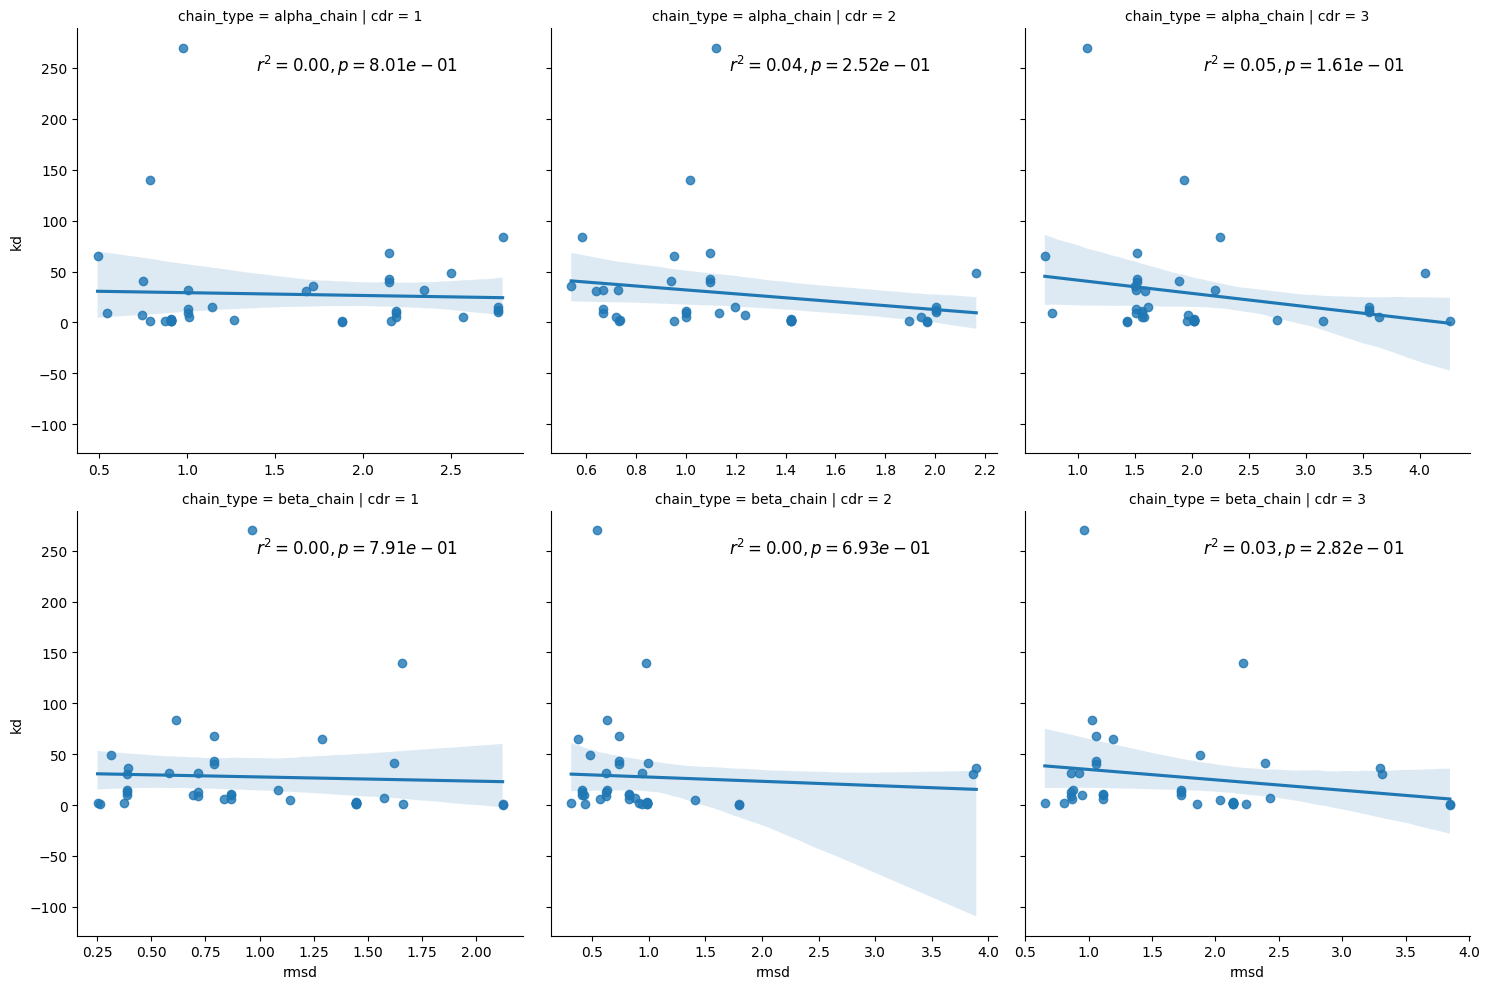

In [27]:
g = sns.lmplot(combined_data_set_norm_tcr, x='rmsd', y='kd', row='chain_type', col='cdr', facet_kws=dict(sharex=False))

def annotate(data, **kws):
    r, p = scipy.stats.pearsonr(data['rmsd'], data['kd'])
    ax = plt.gca()
    ax.text(0.4, 0.9, f'$r^2={r**2:.2f}, p={p:.2e}$', fontsize=12, transform=ax.transAxes)

g.map_dataframe(annotate)

plt.show()

### Conformational change of pMHC versus affinity

In [28]:
combined_data_set_norm_pmhc = combined_data_set_pmhc.groupby(['mhc_slug', 'peptide_sequence', 'domain', 'kd'])['rmsd'].mean().reset_index()

In [29]:
num_pmhcs = len(combined_data_set_norm_pmhc.groupby(['mhc_slug', 'peptide_sequence']))

print('There are', num_pmhcs, 'pMHCs that also have affinity data for there interactions with TCR molecules')

There are 30 pMHCs that also have affinity data for there interactions with TCR molecules


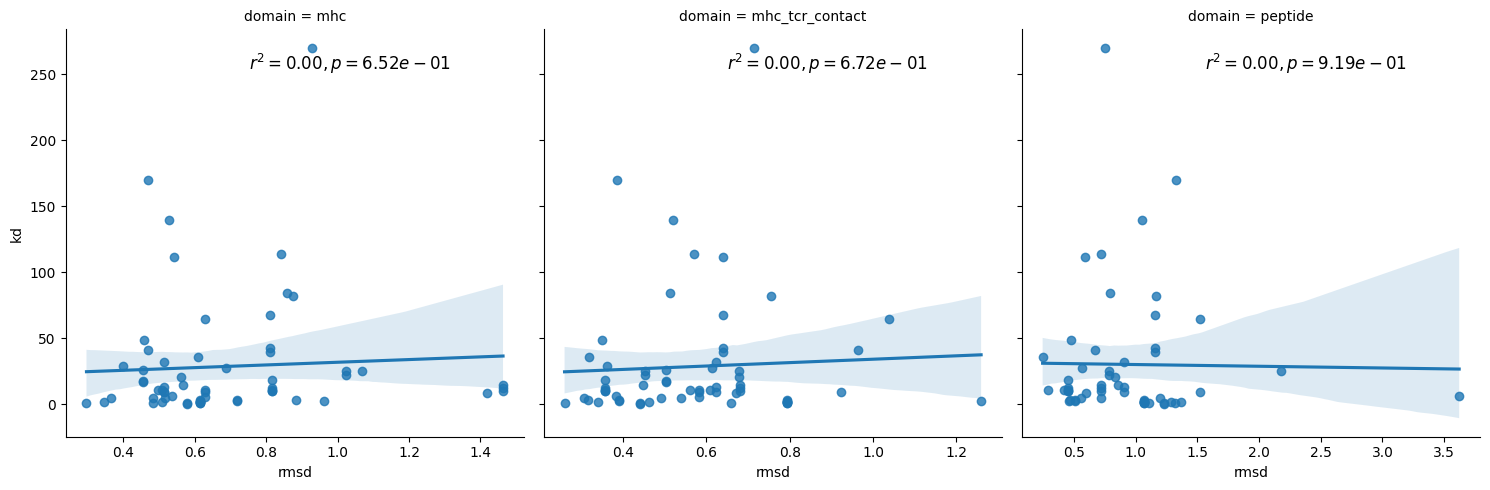

In [30]:
g = sns.lmplot(combined_data_set_norm_pmhc, x='rmsd', y='kd', col='domain', facet_kws=dict(sharex=False))

def annotate(data, **kws):
    r, p = scipy.stats.pearsonr(data['rmsd'], data['kd'])
    ax = plt.gca()
    ax.text(0.4, 0.9, f'$r^2={r**2:.2f}, p={p:.2e}$', fontsize=12, transform=ax.transAxes)

g.map_dataframe(annotate)

plt.show()

## Conclusion

Overall, there seems to be low correlation between the binding affinity of a TCR-pMHC and the amount of conformational change the interface undergoes. Only the CDR-A2, CDR-A3, and CDR-B3 loops had any correlation but even there the correlation was very low (<10%).